In [2]:
#%matplotlib inline
import uproot4
#from ROOT import TH1F
from hist import Hist
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from matplotlib import cm
from matplotlib.colors import LogNorm, Normalize
from uncertainties import unumpy as unp
import numpy as np
import awkward1 as ak
from scipy.optimize import curve_fit
from scipy.stats import crystalball
from scipy.special import erf
from zfit.models.physics import crystalball_func
import math


mpl.rcParams['text.usetex'] = True
plt.rc('text', usetex=False)


/home/name/.local/lib/python3.8/site-packages/zfit/__init__.py:48: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn("TensorFlow warnings are by default suppressed by zfit."


In [3]:
# Open file and get hits in events
root_file = uproot4.open("../work/calib_gam_5GeV_100000evt.root")
ana_file = uproot4.open("../work/calib_gam_5GeV_100000evt.ana.root")
nevents = 300
ana_files = [
uproot4.open('../work/calib_gam_1GeV_100000evt.ana.root'),
uproot4.open('../work/calib_gam_3GeV_100000evt.ana.root'),
uproot4.open('../work/calib_gam_7GeV_100000evt.ana.root'),
uproot4.open('../work/calib_gam_9GeV_100000evt.ana.root')
]


def pdf(x, a=1 / np.sqrt(2 * np.pi), x0=0, sigma=1, offset=0):
    exp = unp.exp if a.dtype == np.dtype("O") else np.exp
    return a * exp(-((x - x0) ** 2) / (2 * sigma ** 2)) + offset

<ipython-input-5-b08064e068cf>:7: RuntimeWarning: invalid value encountered in float_power
  A = np.float_power(n/abs(alpha),n)*np.exp(-1*(alpha**2)/2)
<ipython-input-5-b08064e068cf>:12: RuntimeWarning: invalid value encountered in float_power
  func = np.append(func, [N*A*((np.float_power((B-(x-mean)/sigma),(-1*n))))])


Text(0, 0.5, 'Events')

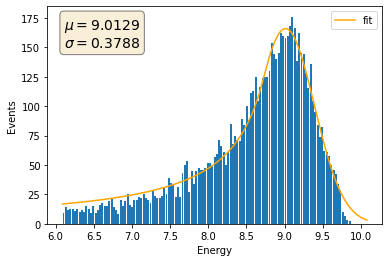

In [5]:
''' --- Crystal ball fit for reconstruction energy --- '''

### --- https://en.wikipedia.org/wiki/Crystal_Ball_function
def crystalball(x, alpha, n, mean, sigma, N):#N=amp
    func = np.array([])
    for x in x:
        A = np.float_power(n/abs(alpha),n)*np.exp(-1*(alpha**2)/2)
        B = (n/abs(alpha))-abs(alpha)
        if((x-mean)/sigma > -1*alpha):
            func = np.append(func, [N*np.exp(-1*((x-mean)**2)/(2*(sigma**2)))])
        elif((x-mean)/sigma <= -1*alpha):
            func = np.append(func, [N*A*((np.float_power((B-(x-mean)/sigma),(-1*n))))])
    return func

### --- https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
def find_nearest(array,value):
    idx,val = min(enumerate(array), key=lambda x: abs(x[1]-value))
    return idx

act_energy = 1 #GeV

#ana_file = uproot4.open(f"../work/calib_gam_3GeV_100000evt.ana.root")
#ana_file = uproot4.open(f"../work/calib_gam_3GeV_100000evt.ana.root")
#ana_file = uproot4.open(f"../work/calib_gam_y100cm_3GeV_10000evt.ana.root")
#ana_file = uproot4.open(f"../work/calib_gam_y80cm_3GeV_10000evt.ana.root")
#ana_file = uproot4.open(f"../work/calib_gam_y126cm_3GeV_10000evt.ana.root")
#ana_file = uproot4.open(f"../work/calib_gam_9GeV_100000evt.ana.root")
ana_file = uproot4.open(f"../work/calib_gam_y126cm_10GeV_10000evt.ana.root")
reco_e = ana_file['ce_emcal_calib;1/reco_energy;1'].to_numpy()
reco_chi2 = ana_file['ce_emcal_calib;1/reco_chi2;1'].to_numpy()

### reduce x range to where energy is
bin_centers = reco_e[1][:-1] + np.diff(reco_e[1]) / 2
energy = np.argmax(reco_e[0])
e_reco = reco_e[1][energy]
e_min = e_reco-3
e_max = e_reco+1
arg_min = find_nearest(reco_e[1], e_min)#; arg_min = arg_min[0][0]
arg_max = find_nearest(reco_e[1], e_max)#; arg_max = arg_max[0][0]

fig, ax = plt.subplots()
### plot histogram
width = .85*(reco_e[1][1] - reco_e[1][0])
#plt.bar(reco_e[1][arg_min:arg_max], reco_e[0][arg_min:arg_max], align='edge', width=width)
#print(len(reco_e[1]))
#print(len(reco_e[0]))
plt.bar(reco_e[1][arg_min:arg_max], reco_e[0][arg_min:arg_max], align='edge', width=width)

### plot fit
beta, m, scale = act_energy, 3, .4
x_interval_for_fit = np.linspace(reco_e[1][arg_min], reco_e[1][arg_max], 10000)
#popt, _ = curve_fit(crystalball, bin_centers[arg_min:arg_max], reco_e[0][arg_min:arg_max], p0=[1, 1, reco_e[1][energy], .05, max(reco_e[0])]) # alpha, n, mean, sigma, amp
popt, _ = curve_fit(crystalball, bin_centers, reco_e[0], p0=[1, 1, reco_e[1][energy], .05, max(reco_e[0])])
fit = crystalball(x_interval_for_fit, *popt)#, 1, 1, 4.81, .05, max(reco_e[0]))#alpha, n, mean, sigma, amp
ax.plot(x_interval_for_fit, fit, label='fit', color="orange")

# place a text box in upper left in axes coords
#textstr = '\n'.join((r'$\mu=%.2f$' % (round(mean,2), ), r'$\sigma=%.2f$' % (round(std, 2), )))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
mean = popt[2]
std = popt[3]
### --- print mean and std on graph
textstr = '\n'.join((r'$\mu=%.4f$' % (round(mean,4), ), r'$\sigma=%.4f$' % (round(std, 4), )))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax.legend()
ax.set_xlabel("Energy")
ax.set_ylabel("Events")

<ipython-input-3-3f033a35f940>:7: RuntimeWarning: invalid value encountered in float_power
  A = np.float_power(n/abs(alpha),n)*np.exp(-1*(alpha**2)/2)
<ipython-input-3-3f033a35f940>:12: RuntimeWarning: invalid value encountered in float_power
  func = np.append(func, [N*A*((np.float_power((B-(x-mean)/sigma),(-1*n))))])
<ipython-input-3-3f033a35f940>:7: RuntimeWarning: overflow encountered in float_power
  A = np.float_power(n/abs(alpha),n)*np.exp(-1*(alpha**2)/2)
<ipython-input-3-3f033a35f940>:12: RuntimeWarning: invalid value encountered in double_scalars
  func = np.append(func, [N*A*((np.float_power((B-(x-mean)/sigma),(-1*n))))])
<ipython-input-3-3f033a35f940>:12: RuntimeWarning: overflow encountered in double_scalars
  func = np.append(func, [N*A*((np.float_power((B-(x-mean)/sigma),(-1*n))))])


Text(0, 0.5, 'Events')

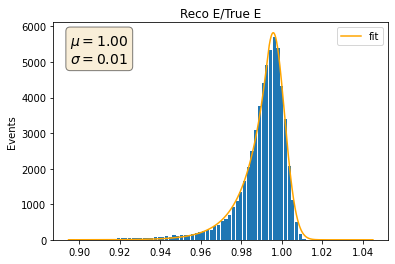

In [3]:
''' --- EJANA RECO ANAYLSIS RECO/TRUE ENERGY FIT --- '''

### --- https://en.wikipedia.org/wiki/Crystal_Ball_function
def crystalball(x, alpha, n, mean, sigma, N):#N=amp
    func = np.array([])
    for x in x:
        A = np.float_power(n/abs(alpha),n)*np.exp(-1*(alpha**2)/2)
        B = (n/abs(alpha))-abs(alpha)
        if((x-mean)/sigma > -1*alpha):
            func = np.append(func, [N*np.exp(-1*((x-mean)**2)/(2*(sigma**2)))])
        elif((x-mean)/sigma <= -1*alpha):
            func = np.append(func, [N*A*((np.float_power((B-(x-mean)/sigma),(-1*n))))])
    return func

### --- https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
def find_nearest(array,value):
    idx,val = min(enumerate(array), key=lambda x: abs(x[1]-value))
    return idx

### --- Get file
jana_file = uproot4.open(f"../work/beagle_100000evt_correct.ana.root")
true_e = jana_file['gen_emcal;1/rec_el_e_tot;1'].to_numpy()
truereco = jana_file['gen_emcal;1/e_truereco;1'].to_numpy()

### --- reduce x range to where energy is
bin_centers = truereco[1][:-1] + np.diff(truereco[1]) / 2
energy = np.argmax(truereco[0])
e_reco = truereco[1][energy]
e_min = e_reco-.1
e_max = e_reco+.05
arg_min = find_nearest(truereco[1], e_min)#; arg_min = arg_min[0][0]
arg_max = find_nearest(truereco[1], e_max)#; arg_max = arg_max[0][0]

fig, ax = plt.subplots()
### --- plot histogram
width = .85*(truereco[1][1] - truereco[1][0])
plt.bar(truereco[1][arg_min:arg_max], truereco[0][arg_min:arg_max], align='edge', width=width) # localized
#plt.bar(truereco[1][:-1], truereco[0], align='edge', width=width) # full

### --- plot fit
x_interval_for_fit = np.linspace(truereco[1][arg_min], truereco[1][arg_max], 10000)
popt, _ = curve_fit(crystalball, bin_centers[arg_min:arg_max], truereco[0][arg_min:arg_max], p0=[1, 1, truereco[1][energy], .05, max(truereco[0])]) # alpha, n, mean, sigma, amp -- localized
#popt, _ = curve_fit(crystalball, bin_centers, truereco[0], p0=[1, 1, truereco[1][energy], .05, max(truereco[0])]) # full
fit = crystalball(x_interval_for_fit, *popt)#, 1, 1, 4.81, .05, max(reco_e[0]))#alpha, n, mean, sigma, amp
ax.plot(x_interval_for_fit, fit, label='fit', color="orange")

### --- Extract mean and standard deviation
rmean = popt[2]
rstd = popt[3]

### --- graph
textstr = '\n'.join((r'$\mu=%.2f$' % (round(rmean,2), ), r'$\sigma=%.2f$' % (round(rstd, 2), )))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax.legend()
title = r'Reco E/True E'
ax.set_title(title)
ax.set_ylabel("Events")


In [ ]:
''' --- EJANA RECO ANAYLSIS RECO ENERGY FIT --- '''

### --- https://en.wikipedia.org/wiki/Crystal_Ball_function
def crystalball(x, alpha, n, mean, sigma, N):#N=amp
    func = np.array([])
    for x in x:
        A = np.float_power(n/abs(alpha),n)*np.exp(-1*(alpha**2)/2)
        B = (n/abs(alpha))-abs(alpha)
        if((x-mean)/sigma > -1*alpha):
            func = np.append(func, [N*np.exp(-1*((x-mean)**2)/(2*(sigma**2)))])
        elif((x-mean)/sigma <= -1*alpha):
            func = np.append(func, [N*A*((np.float_power((B-(x-mean)/sigma),(-1*n))))])
    return func

### --- https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
def find_nearest(array,value):
    idx,val = min(enumerate(array), key=lambda x: abs(x[1]-value))
    return idx

### --- Get file
jana_file = uproot4.open(f"../work/beagle_100000evt.ana.root")
true_e = jana_file['gen_emcal;1/reco_e_tot;1'].to_numpy()
truereco = jana_file['gen_emcal;1/e_truereco;1'].to_numpy()

#for i in range(len(true_e[0])): 
#    true_e[0][i]= true_e[0][i]/rmean

### --- reduce x range to where energy is
bin_centers = true_e[1][:-1] + np.diff(true_e[1]) / 2
energy = np.argmax(true_e[0])
e_reco = true_e[1][energy]
e_min = e_reco-2.5
e_max = e_reco+.5
arg_min = find_nearest(true_e[1], e_min)#; arg_min = arg_min[0][0]
arg_max = find_nearest(true_e[1], e_max)#; arg_max = arg_max[0][0]

fig, ax = plt.subplots()
### --- plot histogram
width = .85*(true_e[1][1] - true_e[1][0])
#plt.bar(true_e[1][arg_min:arg_max], true_e[0][arg_min:arg_max], align='edge', width=width) # localized
plt.bar(true_e[1][:arg_max], true_e[0][0:arg_max], align='edge', width=width) # full

### --- plot fit
#x_interval_for_fit = np.linspace(true_e[1][arg_min], true_e[1][arg_max], 10000) # localized
x_interval_for_fit = np.linspace(true_e[1][0], true_e[1][arg_max], 10000) # full
#popt, _ = curve_fit(crystalball, bin_centers[arg_min:arg_max], true_e[0][arg_min:arg_max], p0=[1, 1, true_e[1][energy], .05, max(true_e[0])]) # alpha, n, mean, sigma, amp -- localized
popt, _ = curve_fit(crystalball, bin_centers[:arg_max], true_e[0][:arg_max], p0=[1, 1, true_e[1][energy], .05, max(true_e[0])]) # full
fit = crystalball(x_interval_for_fit, *popt)#, 1, 1, 4.81, .05, max(reco_e[0]))#alpha, n, mean, sigma, amp
ax.plot(x_interval_for_fit, fit, label='fit', color="orange")

### --- Extract mean and standard deviation
mean = popt[2]
std = popt[3]

### --- graph
textstr = '\n'.join((r'$\mu=%.4f$' % (round(mean,2), ), r'$\sigma=%.4f$' % (round(std, 2), )))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax.legend()
title = r'Reco E'
ax.set_title(title)
ax.set_ylabel("Events")

In [ ]:
''' --- 111111111 Crystal ball fit for reconstruction energy --- '''

### --- https://en.wikipedia.org/wiki/Crystal_Ball_function
def crystalball(x, alpha, n, mean, sigma, N):#N=amp
    func = np.array([])
    for x in x:
        A = np.float_power(n/abs(alpha),n)*np.exp(-1*(alpha**2)/2)
        B = (n/abs(alpha))-abs(alpha)
        if((x-mean)/sigma > -1*alpha):
            func = np.append(func, [N*np.exp(-1*((x-mean)**2)/(2*(sigma**2)))])
        elif((x-mean)/sigma <= -1*alpha):
            func = np.append(func, [N*A*((np.float_power((B-(x-mean)/sigma),(-1*n))))])
    return func

### --- https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
def find_nearest(array,value):
    idx,val = min(enumerate(array), key=lambda x: abs(x[1]-value))
    return idx

act_energy = 10 #GeV
'''ana_file = uproot4.open(f"../work/calib_gam_{act_energy}GeV_100000evt.ana.root")
reco_e = ana_file['ce_emcal_calib;1/reco_energy;1'].to_numpy()
reco_chi2 = ana_file['ce_emcal_calib;1/reco_chi2;1'].to_numpy()'''

ana_file = uproot4.open(f"../work/beagle_100000evt_correct.ana.root")
reco_e = ana_file['gen_emcal;1/reco_e_tot;1'].to_numpy()

### reduce x range to where energy is
bin_centers = reco_e[1][:-1] + np.diff(reco_e[1]) / 2
energy = np.argmax(reco_e[0])
e_reco = reco_e[1][energy]
e_min = e_reco-3
e_max = e_reco+.75
arg_min = find_nearest(reco_e[1], e_min)#; arg_min = arg_min[0][0]
arg_max = find_nearest(reco_e[1], e_max)#; arg_max = arg_max[0][0]

ten = find_nearest(reco_e[1], 10.5)

fig, ax = plt.subplots()
### plot histogram
width = .85*(reco_e[1][1] - reco_e[1][0])
#plt.bar(reco_e[1][arg_min:arg_max], reco_e[0][arg_min:arg_max], align='edge', width=width)
plt.bar(reco_e[1][0:ten], reco_e[0][0:ten], align='edge', width=width)

### plot fit
beta, m, scale = act_energy, 3, .4
#x_interval_for_fit = np.linspace(reco_e[1][0], reco_e[1][500], 10000)
#popt, _ = curve_fit(crystalball, bin_centers, reco_e[0], p0=[1, 1, reco_e[1][energy], .05, max(reco_e[0])])
#x_interval_for_fit = np.linspace(reco_e[1][arg_min], reco_e[1][arg_max], 10000)
#popt, _ = curve_fit(crystalball, bin_centers[arg_min:arg_max], reco_e[0][arg_min:arg_max], p0=[1, 1, reco_e[1][energy], .05, max(reco_e[0])]) # alpha, n, mean, sigma, amp
#fit = crystalball(x_interval_for_fit, *popt)#, 1, 1, 4.81, .05, max(reco_e[0]))#alpha, n, mean, sigma, amp
#ax.plot(x_interval_for_fit, fit, label='fit', color="orange")

# place a text box in upper left in axes coords
#textstr = '\n'.join((r'$\mu=%.2f$' % (round(mean,2), ), r'$\sigma=%.2f$' % (round(std, 2), )))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
mean = popt[2]
std = popt[3]
### --- print mean and std on graph
textstr = '\n'.join((r'$\mu=%.2f$' % (round(mean,2), ), r'$\sigma=%.2f$' % (round(std, 2), )))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax.legend()
ax.set_xlabel("Energy")
ax.set_ylabel("Events")
plt.savefig(f"../Plots_Reco/energy_spectrum",facecolor='w')

<ipython-input-16-162d7e71b5f7>:7: RuntimeWarning: invalid value encountered in float_power
  A = np.float_power(n/abs(alpha),n)*np.exp(-1*(alpha**2)/2)
<ipython-input-16-162d7e71b5f7>:12: RuntimeWarning: invalid value encountered in float_power
  func = np.append(func, [N*A*((np.float_power((B-(x-mean)/sigma),(-1*n))))])
<ipython-input-16-162d7e71b5f7>:7: RuntimeWarning: overflow encountered in float_power
  A = np.float_power(n/abs(alpha),n)*np.exp(-1*(alpha**2)/2)
<ipython-input-16-162d7e71b5f7>:12: RuntimeWarning: invalid value encountered in double_scalars
  func = np.append(func, [N*A*((np.float_power((B-(x-mean)/sigma),(-1*n))))])
<ipython-input-16-162d7e71b5f7>:12: RuntimeWarning: overflow encountered in double_scalars
  func = np.append(func, [N*A*((np.float_power((B-(x-mean)/sigma),(-1*n))))])


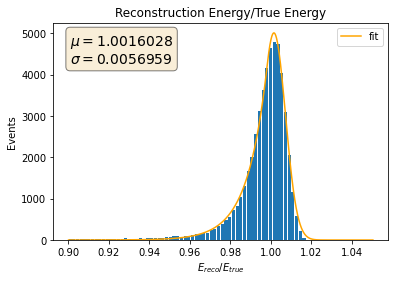

In [16]:
''' --- EJANA RECO ANAYLSIS RECO/TRUE ENERGY FIT --- '''

### --- https://en.wikipedia.org/wiki/Crystal_Ball_function
def crystalball(x, alpha, n, mean, sigma, N):#N=amp
    func = np.array([])
    for x in x:
        A = np.float_power(n/abs(alpha),n)*np.exp(-1*(alpha**2)/2)
        B = (n/abs(alpha))-abs(alpha)
        if((x-mean)/sigma > -1*alpha):
            func = np.append(func, [N*np.exp(-1*((x-mean)**2)/(2*(sigma**2)))])
        elif((x-mean)/sigma <= -1*alpha):
            func = np.append(func, [N*A*((np.float_power((B-(x-mean)/sigma),(-1*n))))])
    return func

### --- https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
def find_nearest(array,value):
    idx,val = min(enumerate(array), key=lambda x: abs(x[1]-value))
    return idx

### --- Get file
jana_file = uproot4.open(f"../work/beagle_100000evt_cali2.ana.root")
true_e = jana_file['gen_emcal;1/rec_el_e_tot;1'].to_numpy()
truereco = jana_file['gen_emcal;1/e_truereco;1'].to_numpy()

### --- reduce x range to where energy is
bin_centers = truereco[1][:-1] + np.diff(truereco[1]) / 2
energy = np.argmax(truereco[0])
e_reco = truereco[1][energy]
e_min = e_reco-.1
e_max = e_reco+.05
arg_min = find_nearest(truereco[1], e_min)#; arg_min = arg_min[0][0]
arg_max = find_nearest(truereco[1], e_max)#; arg_max = arg_max[0][0]

fig, ax = plt.subplots()
### --- plot histogram
width = .85*(truereco[1][1] - truereco[1][0])
plt.bar(truereco[1][arg_min:arg_max], truereco[0][arg_min:arg_max], align='edge', width=width) # localized
#plt.bar(truereco[1][:-1], truereco[0], align='edge', width=width) # full

### --- plot fit
x_interval_for_fit = np.linspace(truereco[1][arg_min], truereco[1][arg_max], 10000)
popt, _ = curve_fit(crystalball, bin_centers[arg_min:arg_max], truereco[0][arg_min:arg_max], p0=[1, 1, truereco[1][energy], .05, max(truereco[0])]) # alpha, n, mean, sigma, amp -- localized
#popt, _ = curve_fit(crystalball, bin_centers, truereco[0], p0=[1, 1, truereco[1][energy], .05, max(truereco[0])]) # full
fit = crystalball(x_interval_for_fit, *popt)#, 1, 1, 4.81, .05, max(reco_e[0]))#alpha, n, mean, sigma, amp
ax.plot(x_interval_for_fit, fit, label='fit', color="orange")

### --- Extract mean and standard deviation
rmean = popt[2]
rstd = popt[3]

### --- graph
textstr = '\n'.join((r'$\mu=%.7f$' % (round(rmean,7), ), r'$\sigma=%.7f$' % (round(rstd, 7), )))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
ax.legend()
title = r'Reconstruction Energy/True Energy'
ax.set_title(title)
ax.set_xlabel(r"$E_{reco}/E_{true}$")
ax.set_ylabel("Events")
plt.savefig(f"../Plots_Reco/cali2_recotrue_cali",facecolor='w')

mean:  4.81
std:   0.17
[4.80863129e+00 8.62309312e+03 4.08560158e-02]


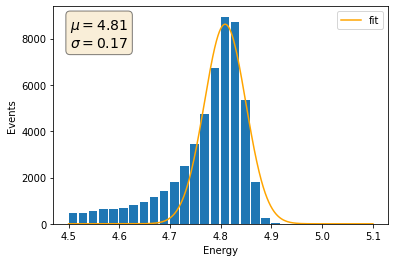

In [6]:
'''GAUSSIAN FUNCTION'''

### --- https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
def find_nearest(array,value):
    idx,val = min(enumerate(array), key=lambda x: abs(x[1]-value))
    return idx

### --- https://stackoverflow.com/questions/35544233/fit-a-curve-to-a-histogram-in-python
def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp( - (x - mean)**2 / (2*standard_deviation ** 2))

act_energy = 5 #GeV
ana_file = uproot4.open(f"../work/calib_gam_{act_energy}GeV_100000evt.ana.root")
reco_e = ana_file['ce_emcal_calib;1/reco_energy;1'].to_numpy()
reco_chi2 = ana_file['ce_emcal_calib;1/reco_chi2;1'].to_numpy()

### reduce x range to where energy is
bin_centers = reco_e[1][:-1] + np.diff(reco_e[1]) / 2
energy = np.argmax(reco_e[0])
e_min = reco_e[1][energy]-.3
e_max = reco_e[1][energy]+.3
arg_min = find_nearest(reco_e[1], e_min)#; arg_min = arg_min[0][0]
arg_max = find_nearest(reco_e[1], e_max)#; arg_max = arg_max[0][0]

x_interval_for_fit = np.linspace(reco_e[1][arg_min], reco_e[1][arg_max], 10000)
popt, _ = curve_fit(gaussian, reco_e[1][arg_min:arg_max], bin_centers[arg_min:arg_max], p0=[1., 0., act_energy])
gauss = gaussian(x_interval_for_fit, *popt)
gauss_mean = np.mean(gauss)
gauss_std = np.std(gauss)
print("mean: ", round(gauss_mean,2))
print("std:  ", round(gauss_std, 2))

### plot fit
popt, _ = curve_fit(gaussian, bin_centers[arg_min:arg_max], reco_e[0][arg_min:arg_max], p0=[act_energy,max(reco_e[0]),1.])#mean, amplitude, standard_deviation
gauss = gaussian(x_interval_for_fit, *popt)
print(popt)
fig, ax = plt.subplots()
### plot histogram
width = .85*(reco_e[1][1] - reco_e[1][0])
plt.bar(reco_e[1][arg_min:arg_max], reco_e[0][arg_min:arg_max], align='edge', width=width)
textstr = '\n'.join((
    r'$\mu=%.2f$' % (round(gauss_mean,2), ),
    r'$\sigma=%.2f$' % (round(gauss_std, 2), )))


# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.plot(x_interval_for_fit, gauss, label='fit', color="orange")
ax.legend()
ax.set_xlabel("Energy")
ax.set_ylabel("Events")
plt.savefig(f"Fits/plot_{act_energy}GeV_recoe_fit",facecolor='w')

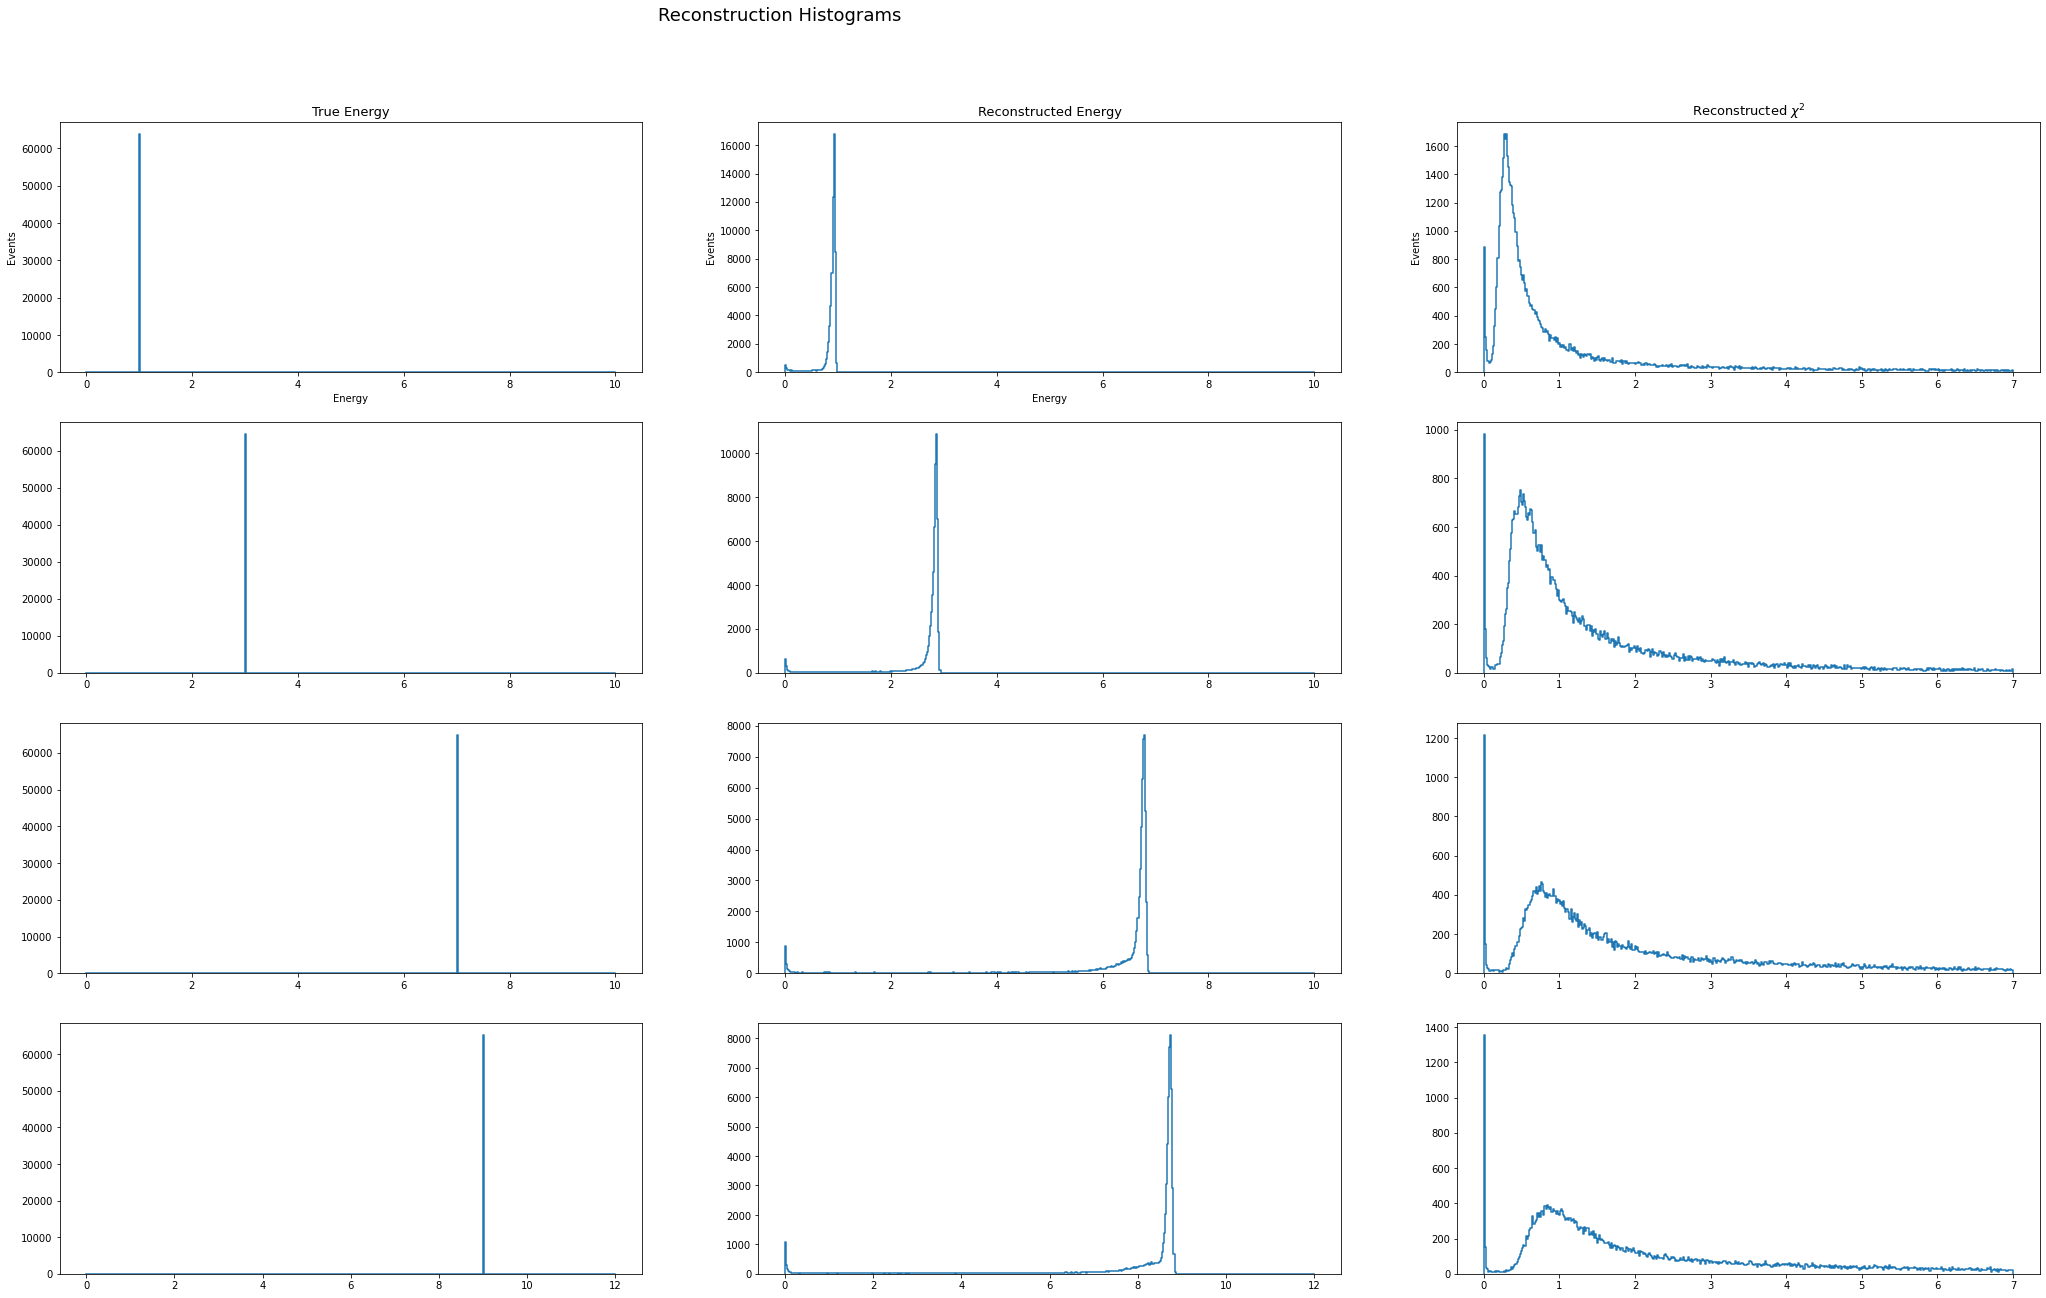

In [11]:
fig, ax = plt.subplots(len(ana_files), 3)#subplots(3, len(ana_files))
plt.suptitle("Reconstruction Histograms", fontsize=18)
fig.set_figheight(20)
fig.set_figwidth(25)
fig.subplots_adjust(left  = 0.1, right = 1.2, bottom = 0.1, top = .9, wspace = 0.2, hspace = 0.2)
plt.rc('text', usetex=False)
ax[0][0].set_title(r'True Energy', fontsize=13)
ax[0][1].set_title(r'Reconstructed Energy', fontsize=13)
#ax[0][2].set_title(r'CMP Energy', fontsize=13)
ax[0][2].set_title(r'Reconstructed $\chi^2$', fontsize=13)
ax[0][0].set_xlabel("Energy")
ax[0][0].set_ylabel("Events")
ax[0][1].set_xlabel("Energy")
ax[0][1].set_ylabel("Events")
#ax[0][2].set_xlabel("Energy")
#ax[0][2].set_ylabel("Events")
#ax[0][2].set_xlabel("Reconstruction Energy/True Energy")
ax[0][2].set_ylabel("Events")
for i, file_path in enumerate(ana_files):
    file_path['ce_emcal_calib;1/true_energy;1'].to_hist().plot(ax=ax[i][0])
    file_path['ce_emcal_calib;1/reco_energy;1'].to_hist().plot(ax=ax[i][1])
    #file_path['ce_emcal_calib;1/cmp_energy;1'].to_hist().plot(ax=ax[i][2])
    file_path['ce_emcal_calib;1/reco_chi2;1'].to_hist().plot(ax=ax[i][2])
    